In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

import time
from datetime import timedelta

import matplotlib.image as mpimg

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "./tests/sanity_check_high_dim"
PROFILE = "1layer-32-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["DEVICE"] = "cuda:1"
#DEVICE = "cuda:1"
DEVICE = "cpu"

====== Generating profile sin-10x-10k-s05 ======
Train: (-5, 5)
Y-space: -50.460201237842206 - 47.71621762355431
In Domain: (-5, 5)
Y-space: -39.172217461782324 - 38.062232373298784
Out Domain: (-10, 10)
Y-space: -47.124966427180766 - 45.249359783935695


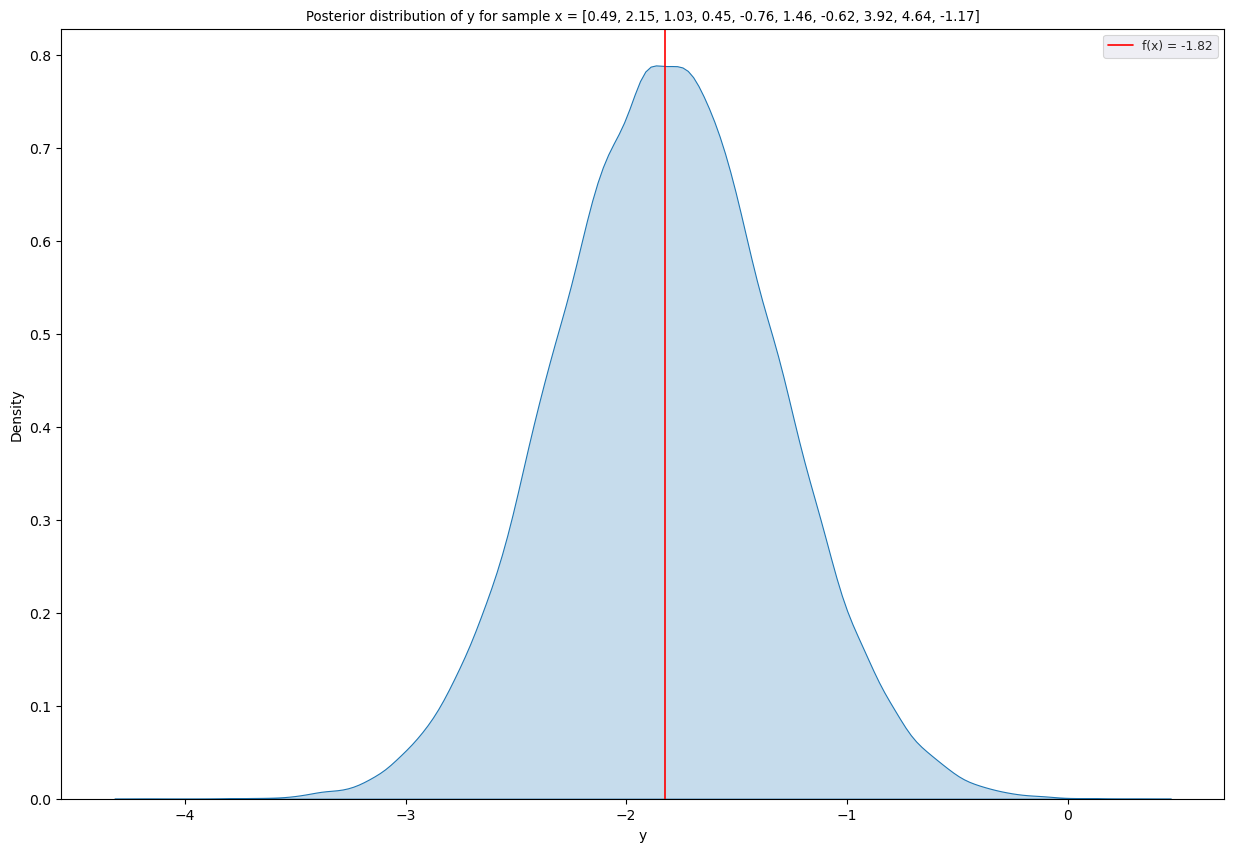

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([10000, 10]), torch.Size([10000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

In [10]:
net = nn.Sequential(nn.Linear(10, 1024), nn.ReLU(), nn.Linear(1024, 1)).to(DEVICE)
#net = nn.Linear(1, 1)

In [11]:
prior = tyxe.priors.IIDPrior(dist.Normal(torch.tensor(0., device=DEVICE), torch.tensor(1., device=DEVICE)))

In [12]:
print(len(x_train))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(5.), constraint=dist.constraints.positive))
scale = dist.Gamma(torch.tensor(1., device=DEVICE), torch.tensor(1., device=DEVICE))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(dataset_size=len(x_train), scale=scale)
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.5)
#obs_model = tyxe.likelihoods.SigmaDistGaussian(len(x_train), scale_loc=0.01, scale_scale=0.01)

#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train), scale=5.0)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d

likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None


10000


In [13]:
obs_model._scale

tensor(3.7806)

In [14]:
import pyro.infer.autoguide.initialization as ag_init
def init_fn (*args, **kwargs):
    return ag_init.init_to_median(*args, **kwargs).to(DEVICE) 
guide_builder = partial(tyxe.guides.AutoNormal, init_loc_fn=init_fn, init_scale=0.01)

In [15]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [16]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

print("DEVICE: ", DEVICE)
start = time.time()

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 10, callback=callback, num_particles=1, device=DEVICE)

end = time.time()
print("runtime: ", timedelta(seconds=end-start))

DEVICE:  cpu
epoch: 0 | elbo: 29900532.65822785
runtime:  0:00:11.760904


In [17]:
#pickle.dump(bnn, open(f"{BASE_DIR}/models/{NAME}.pkl", "wb"))

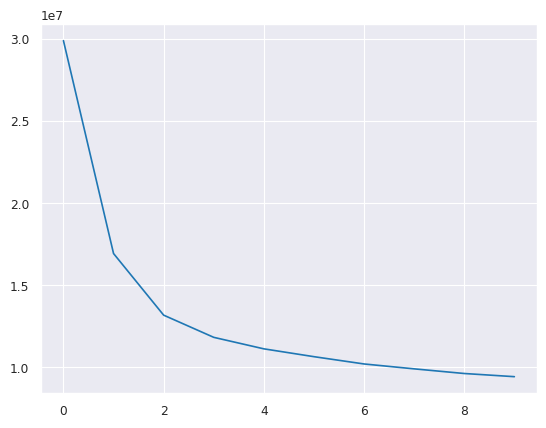

In [18]:
plt.plot(elbos)

In [19]:
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=bnn)

FileNotFoundError: [Errno 2] No such file or directory: './tests/sanity_check_high_dim/results/1layer-32-s05'

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/train_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_in_domain_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_out_domain_sanity.png"))